In [1]:
# Standard Python built-in libraries
from functools import partial

# Numerical libraries
import numpy as np
import pandas as pd

# Datashader Big Data Visualization
import datashader as ds
from datashader import transfer_functions as tf

# Convert Longitude-Latitude coordinates into Web Mercator X-Y Values
from datashader.utils import lnglat_to_meters as webm

# Export a datashader plot to an image file (e.g. jpg/png)
from datashader.utils import export_image

# Color Maps
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from matplotlib.cm import hot
from colorcet import fire

# Interactive images
from bokeh.plotting import figure, output_notebook, show
from datashader.bokeh_ext import InteractiveImage

# Overlay our data on a Real Map
from bokeh.tile_providers import STAMEN_TERRAIN

In [2]:
%%time
df1 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2005_to_2007.csv',low_memory=False)
df2 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2009_to_2011.csv',low_memory=False)
df3 = pd.read_csv('/Users/user/Desktop/application/DHL/accidents_2012_to_2014.csv',low_memory=False)

# check if the three datasets have same column headers
df1.columns.difference(df2.columns).difference(df3.columns)

# combine three datasets into one
df = pd.concat([df1, df2, df3],ignore_index=True)

print('Number of rows and collumns',df1.shape,df2.shape,df3.shape,df.shape)

Number of rows and collumns (570011, 33) (469442, 33) (464697, 33) (1504150, 33)
CPU times: user 11.1 s, sys: 1.86 s, total: 12.9 s
Wall time: 13.1 s


For our visualization analysis, we pick only a small number of columns specifically longitude, latitude and road_type.

In [11]:
df = df[['Longitude','Latitude', 'Road_Type']]
df['Road_Type'] = df['Road_Type'].astype('category')# take a peek at Road_Type values & count
df.groupby(['Road_Type']).size()

Road_Type
Dual carriageway       221741
One way street          30981
Roundabout             100463
Single carriageway    1126951
Slip road               15668
Unknown                  8346
dtype: int64

In [12]:
df.head()

Longitude   Latitude           Road_Type
0  -0.191170  51.489096  Single carriageway
1  -0.211708  51.520075    Dual carriageway
2  -0.206458  51.525301  Single carriageway
3  -0.173862  51.482442  Single carriageway
4  -0.156618  51.495752  Single carriageway

# Obtain Web Mercator X-Y Values

The traffic data we obtain contains the geographical coordinates Longitude and Latitude. In order to project onto a 2D Web Mercator map later, we need to compute the Web Mercator X-Y values (from Longitude and Latitude values). Fortunately we've imported a handy utility webm that can easily convert Longitude and Latitude into Web Mercator x and y values to do this.

In [14]:
# computer Mercator x and y values from Longitude and Latitude
x, y = [c for c in list(webm(df.loc[:, 'Longitude'], df.loc[:, 'Latitude']))]

# add as new columns called `webm_x` and `webm_y `in our dataframe df
df = df.assign(webm_x=x).copy()
df = df.assign(webm_y=y).copy()

# take a peek
df.tail()

Longitude   Latitude           Road_Type         webm_x        webm_y
1504145  -3.417278  55.264773    Dual carriageway -380409.646859  7.413424e+06
1504146  -3.230255  55.054855    Dual carriageway -359590.341732  7.372520e+06
1504147  -3.230826  54.985668  Single carriageway -359653.905162  7.359085e+06
1504148  -3.191397  54.990446  Single carriageway -355264.688959  7.360012e+06
1504149  -3.348426  55.106700  Single carriageway -372745.077279  7.382602e+06

In [17]:
# in lng/lats, manually obatained from Open Street Map
# https://www.openstreetmap.org/export
# feel free to add some of your own!
bboxes = {
  "gb": ((-15.381, 7.251), (48.749, 61.502)),
  "gb_mainland": ( (-12.129, 5.120), (49.710, 58.745)),
  "gb_long": ((-8.745, 2.241), (48.749, 61.502)),
  "gb_wide": ((-21.709, 15.293), (48.749, 61.502)),
  "london": ((-0.643, 0.434), (51.200, 51.761)),
  "london_2": ((-0.1696, 0.0130), (51.4546, 51.5519)),
  "london_3": ((-0.1330, -0.0235), (51.4741, 51.5322)),  
  "manchester": ((-3.049, -1.505), (52.975, 53.865))
 }

In [18]:
# default plot width
PLOT_WIDTH= 750

def get_plot_size(x_range, y_range, plot_width=PLOT_WIDTH):
  """returns a tuple (plot_width, plot_height) in pixels

    Args:
      x_range (float): bounding box Web Mercator tuple X range in meters (min_x, max_x)
      y_range (float): bounding box Web Mercator tuple Y range in meters (min_y, max_y)
      plot_width (int): the desirable plot width in pixel

    Returns:
      plot_width (int), plot_height (int)

  """

  # compute X and Y distances
  x_range_dist = x_range[1] - x_range[0]
  y_range_dist = y_range[1] - y_range[0]
  plot_height = int(y_range_dist * plot_width /x_range_dist)
  return (plot_width, plot_height)

In [19]:

# for our britian example, this is how we get our bounding box in different formats
# Note our use of tuple destructuring (with the *)
print("Britian Bounding Box")
print("  - in lng/lat ranges: {}".format(bboxes["gb"]))
print("  - in Web Mercator X-Y ranges: {}".format(webm(*bboxes["gb"])))
print("  - in Plot width-height: {}".format(get_plot_size(*webm(*bboxes["gb"]))))

Britian Bounding Box
  - in lng/lat ranges: ((-15.381, 7.251), (48.749, 61.502))
  - in Web Mercator X-Y ranges: (array([-1712205.08789134,   807177.62774203]), array([ 6232378.76591682,  8742012.04392761]))
  - in Plot width-height: (750, 747)


In [20]:
# create a utility function so we can reuse easily later
def get_plot_params(bbox, plot_width=PLOT_WIDTH):
  """returns the Web Mercator x_range and y_range in meters, and plot_width and plot_height in pixels.

  Args:
    bbox: bounding box Web Mercator tuple (longitude_range, latitude_range) in degrees.
          i.e. ((min_longitude, max_latitude), (min_latitude, max_latitude))
    plot_width (int): the desirable plot width in pixel

  Returns:
    x_range, y_range, plot_width, plot_height

  """
  
  x_range, y_range = webm(*bbox)
  plot_width, plot_height = get_plot_size(x_range, y_range, plot_width=plot_width)
  return x_range, y_range, plot_width, plot_height

In [21]:
# Try it!
get_plot_params(bboxes["gb"])

(array([-1712205.08789134,   807177.62774203]),
 array([ 6232378.76591682,  8742012.04392761]),
 750,
 747)

In [22]:
background = "black"

In [23]:
# utility function: to enable us to export a plot to an image file, with default parameters (e.g. background)
export = partial(export_image, background=background, export_path="export")

# utility function: color map
cm = partial(colormap_select, reverse=(background!="black"))

# Traffic Accident Density

For our first examples, let's ignore the Road_Type category for now, focusing on population density alone. We'll first aggregate all the data points into a grid containing the population density per pixel:

In [25]:
%%time
x_range, y_range, plot_width, plot_height = get_plot_params(bboxes["gb"])
cvs = ds.Canvas(plot_width, plot_height, x_range, y_range)
agg = cvs.points(df, 'webm_x', 'webm_y')

CPU times: user 19.6 ms, sys: 7.08 ms, total: 26.7 ms
Wall time: 24.3 ms


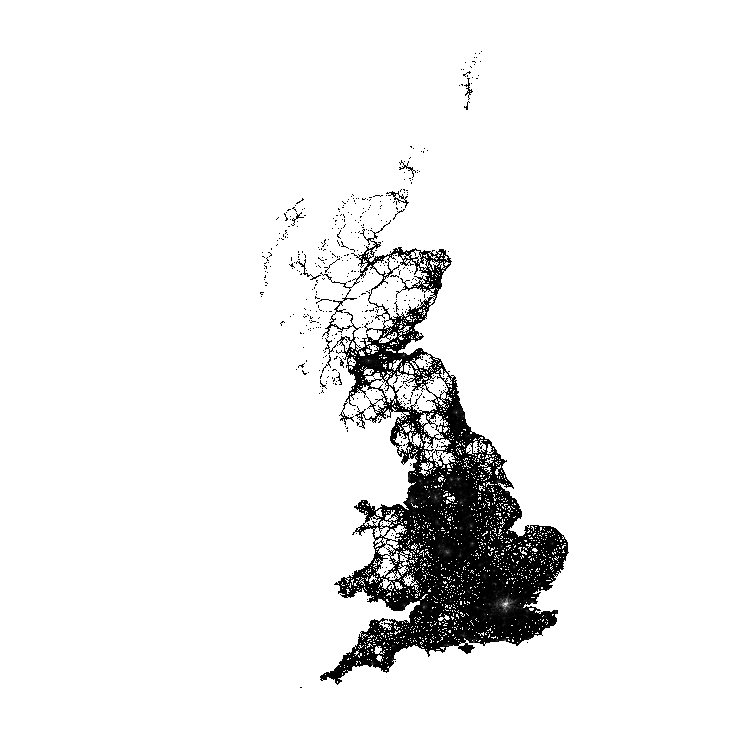

In [26]:
tf.shade(agg, cmap = cm(Greys9), how='linear')

This image shows that our traffic accident data points cover pretty much the entire Britian - the fact that we have accidents reported at nearly every spot in Britian is pretty astonishing.

But wait. Shouldn't we get a black background instead (as we configured previously)? Yes we should - if we had used the utility function export that we defined earlier. It will also save the image as a .png file under the export directory (that we defined in our utility function export previously). Let's give it another go (spoiler alert: expect an almost pitch black imge).

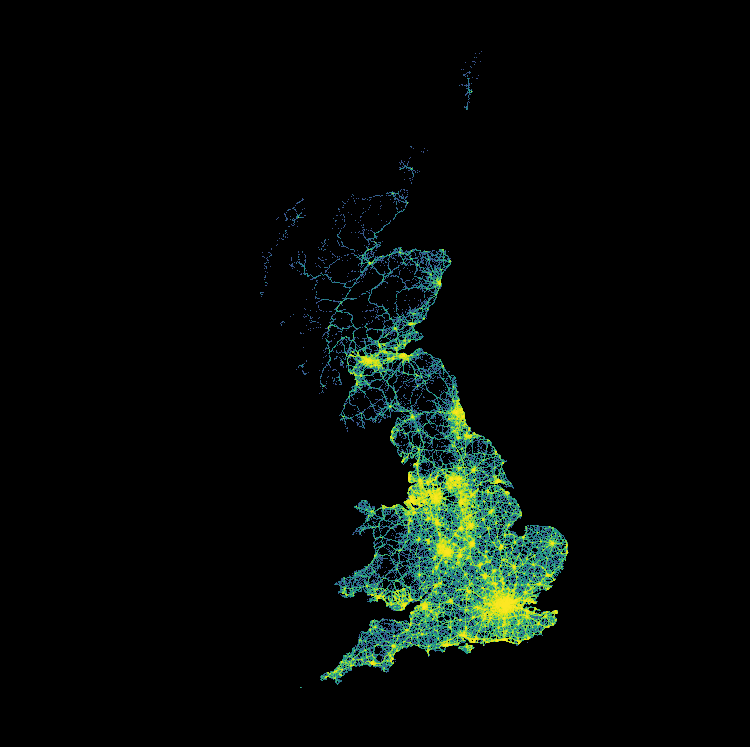

In [27]:
# from datashader.colors import viridis
export(tf.shade(agg, cmap=cm(viridis, 0.25), how='eq_hist'),"gb_viridis_eq_hist_0.25")

Where were the top 1% traffic accidents reported during 2005-2007?
Colormaps can be used to address very specific questions about the data itself. For instance, after histogram equalization, data should be uniformly distributed across the visible colormap. Thus if we want to highlight e.g. the top 1% of pixels, by traffic accident density, we can use a colormap divided into 100 ranges, and just change the top one to a different color:

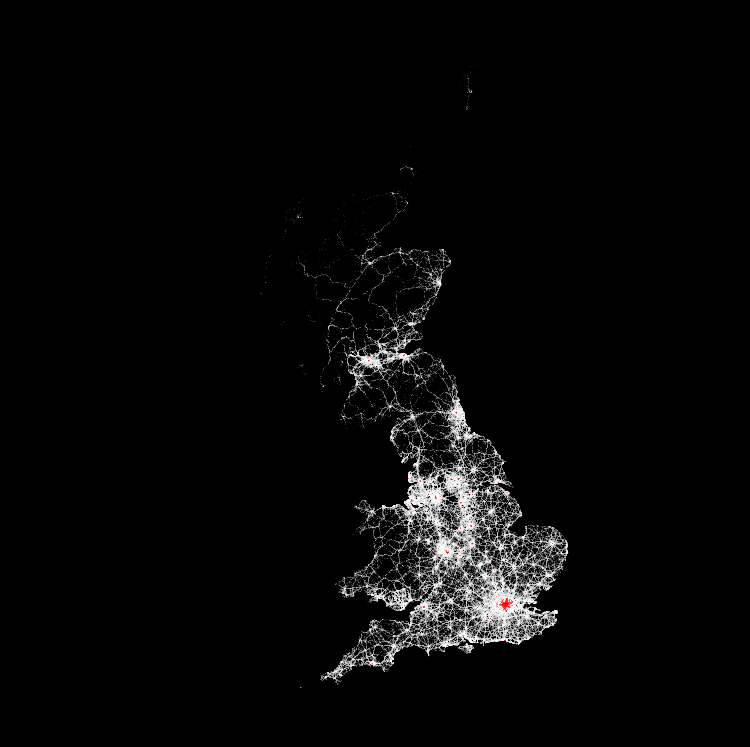

In [30]:
top_x_percent = 1 # change this to 5 for top 5%, etc.

grays2 = cm([(i,i,i) for i in np.linspace(0,255,(100-top_x_percent))])
grays2 += ["red"]
export(tf.shade(agg, cmap=grays2, how='eq_hist'),"gb_gray_redhot1_eq_hist")

Observation: we can clearly see the top 1% of accidents reported occur in these major cities:


$
\text{England: London, Birmingham, Liverpool, Manchester, Leeds, Newcastle, Noriwch, and Bristol} \\ 
\text{Wales: Cardiff.} \\
\text{Scotland: Edinburgh, Glassgow, Aberdeen} \\
$

The above plot now conveys nearly all the information available in the linear plot, i.e. that only a few pixels have the very highest population densities, while also conveying the structure of the data at all population density ranges via histogram equalization. And in no case was any parameter value chosen based on the data itself, just on the question we wanted to ask about the data, which is crucial for posing and answering questions objectively using visualizations.

## Now we plot for specific regions

In [31]:
# take a peek at our bounding boxes again (lng, lat)
bboxes

{'gb': ((-15.381, 7.251), (48.749, 61.502)),
 'gb_long': ((-8.745, 2.241), (48.749, 61.502)),
 'gb_mainland': ((-12.129, 5.12), (49.71, 58.745)),
 'gb_wide': ((-21.709, 15.293), (48.749, 61.502)),
 'london': ((-0.643, 0.434), (51.2, 51.761)),
 'london_2': ((-0.1696, 0.013), (51.4546, 51.5519)),
 'london_3': ((-0.133, -0.0235), (51.4741, 51.5322)),
 'manchester': ((-3.049, -1.505), (52.975, 53.865))}

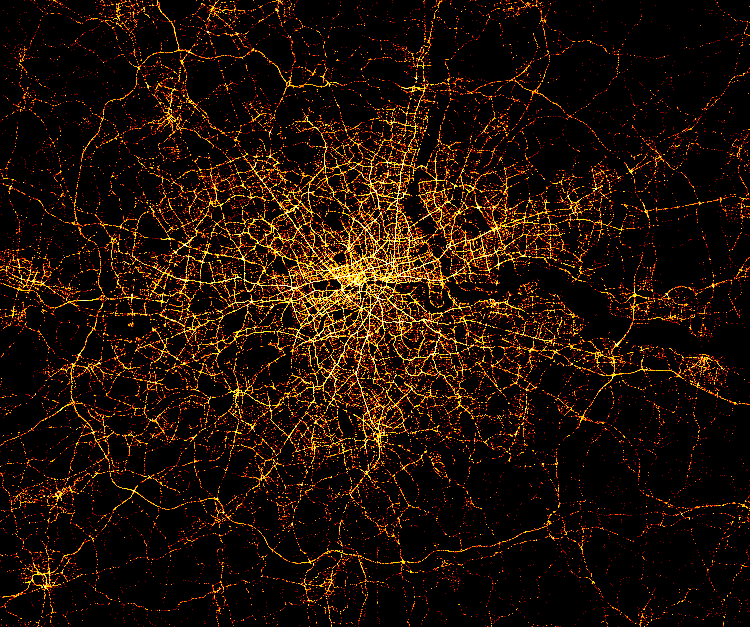

In [32]:
# Let's do London this time
x_range, y_range, plot_width, plot_height = get_plot_params(bboxes["london"])
cvs = ds.Canvas(plot_width, plot_height, x_range, y_range)
agg = cvs.points(df, 'webm_x', 'webm_y')
export(tf.shade(agg, cmap=cm(Hot, 0.25), how='eq_hist'),"london_Hot_eq_hist_0.25")

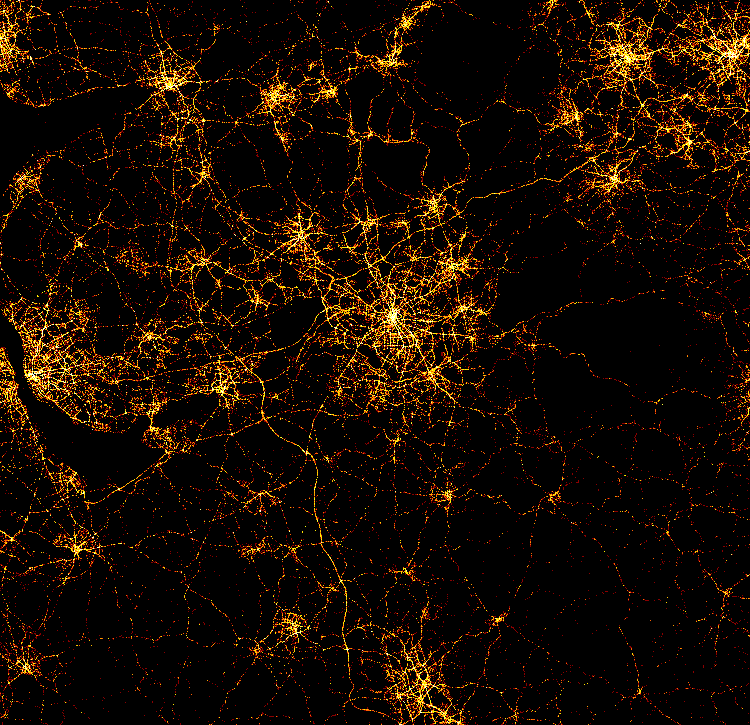

In [34]:
# And do the same for Manchester
x_range, y_range, plot_width, plot_height = get_plot_params(bboxes["manchester"])
cvs = ds.Canvas(plot_width, plot_height, x_range, y_range)
agg = cvs.points(df, 'webm_x', 'webm_y')
export(tf.shade(agg, cmap=cm(Hot, 0.25), how='eq_hist'),"manchester_Hot_eq_hist_0.25")

# Interactive Image

In [35]:
# from bokeh.plotting import output_notebook
# if this steps run ok you will see "BokehJS 0.12.10 successfully loaded."
output_notebook()

Loading BokehJS ...

In [36]:
# from bokeh.plotting import figure
def base_plot(x_range, y_range, plot_width, plot_height,
              tools='pan, wheel_zoom, reset, save', **plot_args):
      
    p = figure(
      x_range=x_range,
      y_range=y_range,
      plot_width=plot_width,
      plot_height=plot_height,
      tools=tools,
      outline_line_color=None,
      min_border=0,
      min_border_left=0,
      min_border_right=0,
      min_border_top=0,
      min_border_bottom=0,
      **plot_args)
    
    p.axis.visible = False 
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

In [37]:
# import datashader as ds
# from datashader import transfer_functions as tf

# format...
# fn(x_range=(xmin, xmax), y_range=(ymin, ymax),w, h, **kwargs)
def create_image(x_range, y_range, w, h):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_width=w, plot_height=h)
    agg = cvs.points(df, 'webm_x', 'webm_y',  ds.count())
    img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

# Visualize Traffic Accident Density Based on Road Type

In [38]:
df.groupby(['Road_Type']).size()

Road_Type
Dual carriageway       221741
One way street          30981
Roundabout             100463
Single carriageway    1126951
Slip road               15668
Unknown                  8346
dtype: int64

In [40]:
# https://bokeh.pydata.org/en/latest/docs/reference/colors.html
color_key = {
  'Dual carriageway':'red',
  'One way street':'orange',
  'Roundabout':'yellow',
  'Single carriageway':'green',
  'Slip road':'blue',
  'Unknown':'purple'
}

In [41]:
def agg_by_road_type(x_range, y_range, w, h):
  cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_width=w, plot_height=h)
  agg = cvs.points(df, 'webm_x', 'webm_y',  ds.count_cat('Road_Type'))
  img = tf.shade(agg, cmap=Hot, color_key=color_key, how='eq_hist')
  return tf.dynspread(img, threshold=0.5, max_px=4)

In [42]:
p = base_plot(*get_plot_params(bboxes["london"]), background_fill_color=background)
# p.add_tile(STAMEN_TERRAIN)  # overlay our plot on a STAMEN_TWERRAIN map
InteractiveImage(p, agg_by_road_type)

In [43]:
p = base_plot(*get_plot_params(bboxes["manchester"]), background_fill_color=background)
# p.add_tile(STAMEN_TERRAIN)  # overlay our plot on a STAMEN_TWERRAIN map
InteractiveImage(p, agg_by_road_type)